In [1]:
! pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"sayansh001","key":"bb83f534024ea023f7468a775ff3e4f2"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 735M/745M [00:08<00:00, 104MB/s] 
100% 745M/745M [00:08<00:00, 92.1MB/s]


In [2]:
! unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [3]:
import shutil

In [4]:
shutil.rmtree('/content/COVID-19_Radiography_Dataset/Viral Pneumonia', ignore_errors=True)

In [5]:
shutil.rmtree('/content/COVID-19_Radiography_Dataset/Lung_Opacity', ignore_errors=True)
! rm /content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
! rm /content/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
! rm /content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
! rm /content/COVID-19_Radiography_Dataset/README.md.txt

Delete the file 
! rm /content/COVID-19_Radiography_Dataset/Viral_Pneumonia.metadata.xlsx 
manually

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random
from keras.preprocessing.image import load_img

In [7]:
data = []
label = []

for class_name in os.listdir("/content/COVID-19_Radiography_Dataset"):
    for path in os.listdir("/content/COVID-19_Radiography_Dataset/"+class_name):
        if class_name=="COVID":
            label.append(0)
        else:
            label.append(1)
        data.append(os.path.join("/content/COVID-19_Radiography_Dataset",class_name,path))
print(data[0],label[0])

/content/COVID-19_Radiography_Dataset/COVID/COVID-1364.png 0


In [8]:
print(data[845],label[845])

/content/COVID-19_Radiography_Dataset/COVID/COVID-647.png 0


In [9]:
len(data)

13808

In [10]:
df = pd.DataFrame()
df['images']=data
df['label']=label
df = df.sample(frac=1).reset_index(drop=True)
#frac = 1 ensures that it will return all rows
df.head()

,images,label
0,/content/COVID-19_Radiography_Dataset/Normal/N...,1
1,/content/COVID-19_Radiography_Dataset/Normal/N...,1
2,/content/COVID-19_Radiography_Dataset/Normal/N...,1
3,/content/COVID-19_Radiography_Dataset/COVID/CO...,0
4,/content/COVID-19_Radiography_Dataset/COVID/CO...,0


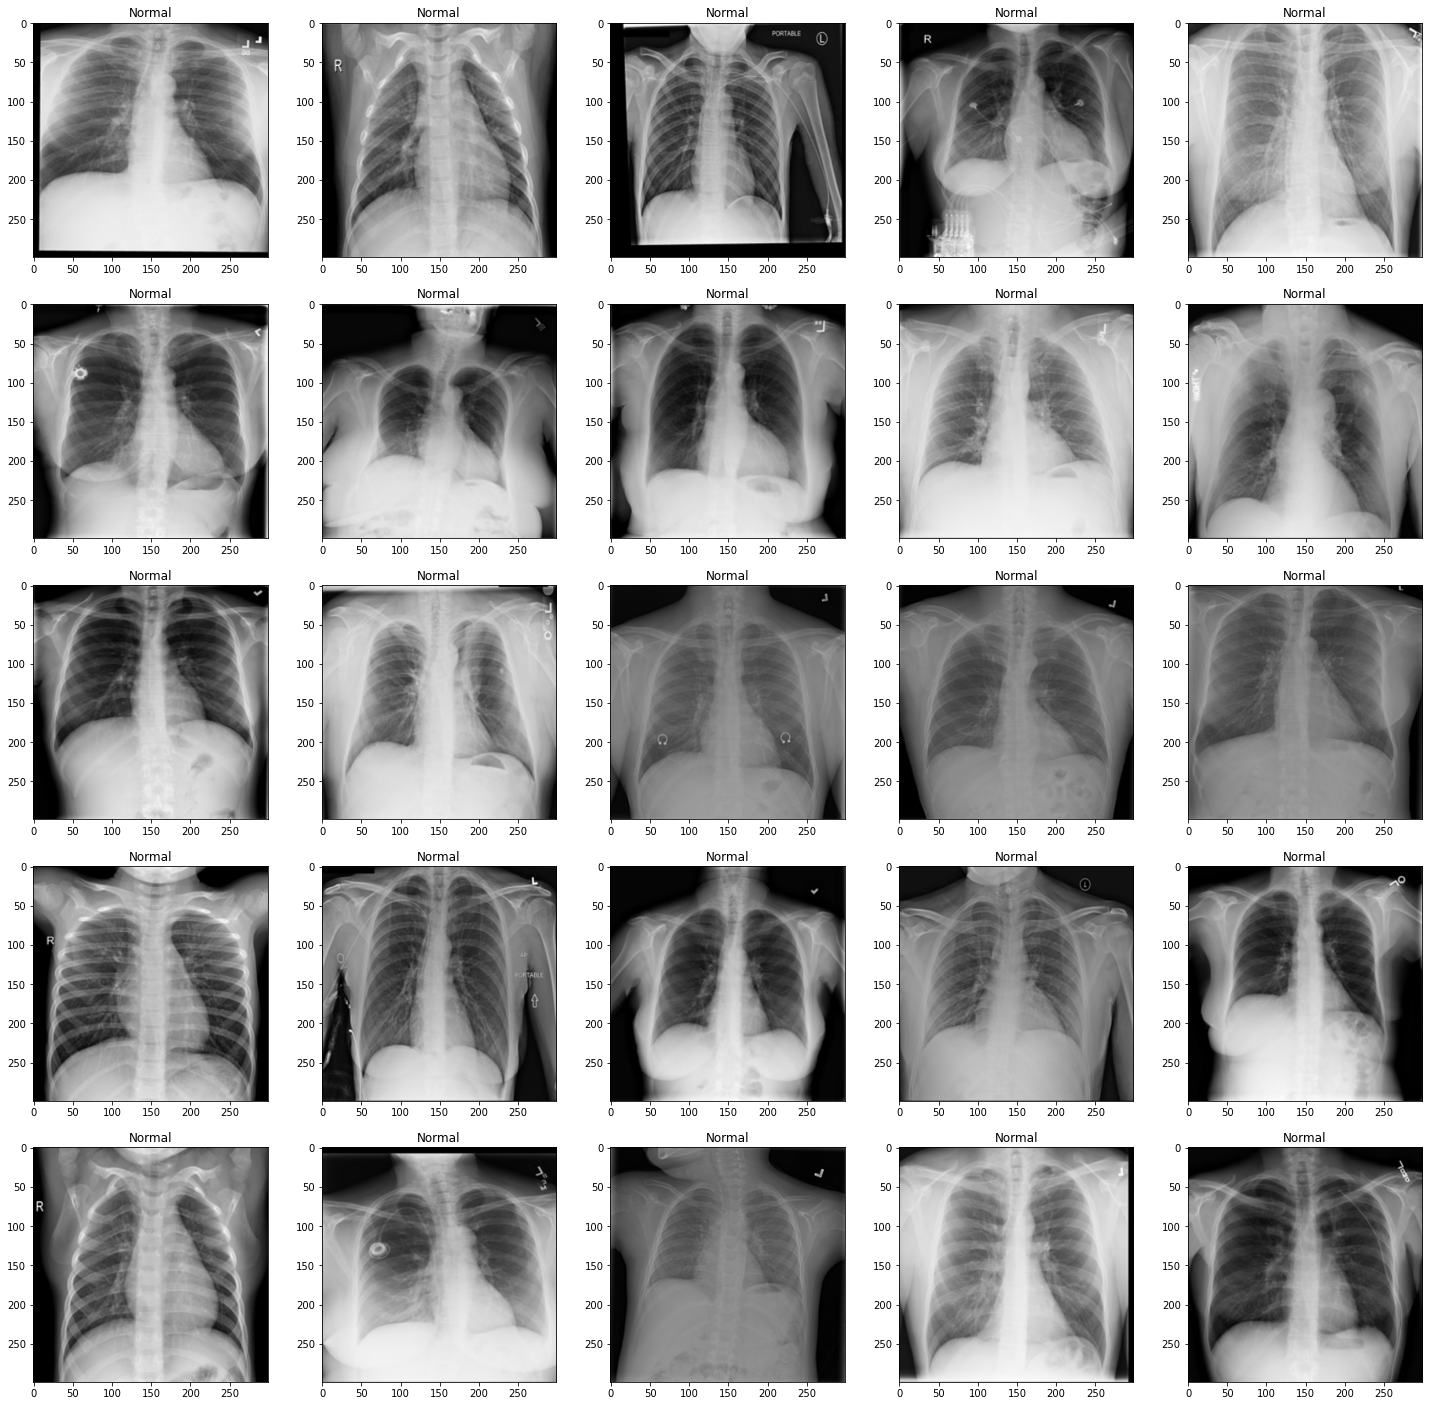

In [11]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']  
start = random.randint(0,len(temp))  
files = temp[start:start+25]        
                                    
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.imshow(img)
  plt.title('Normal')
  plt.axis()

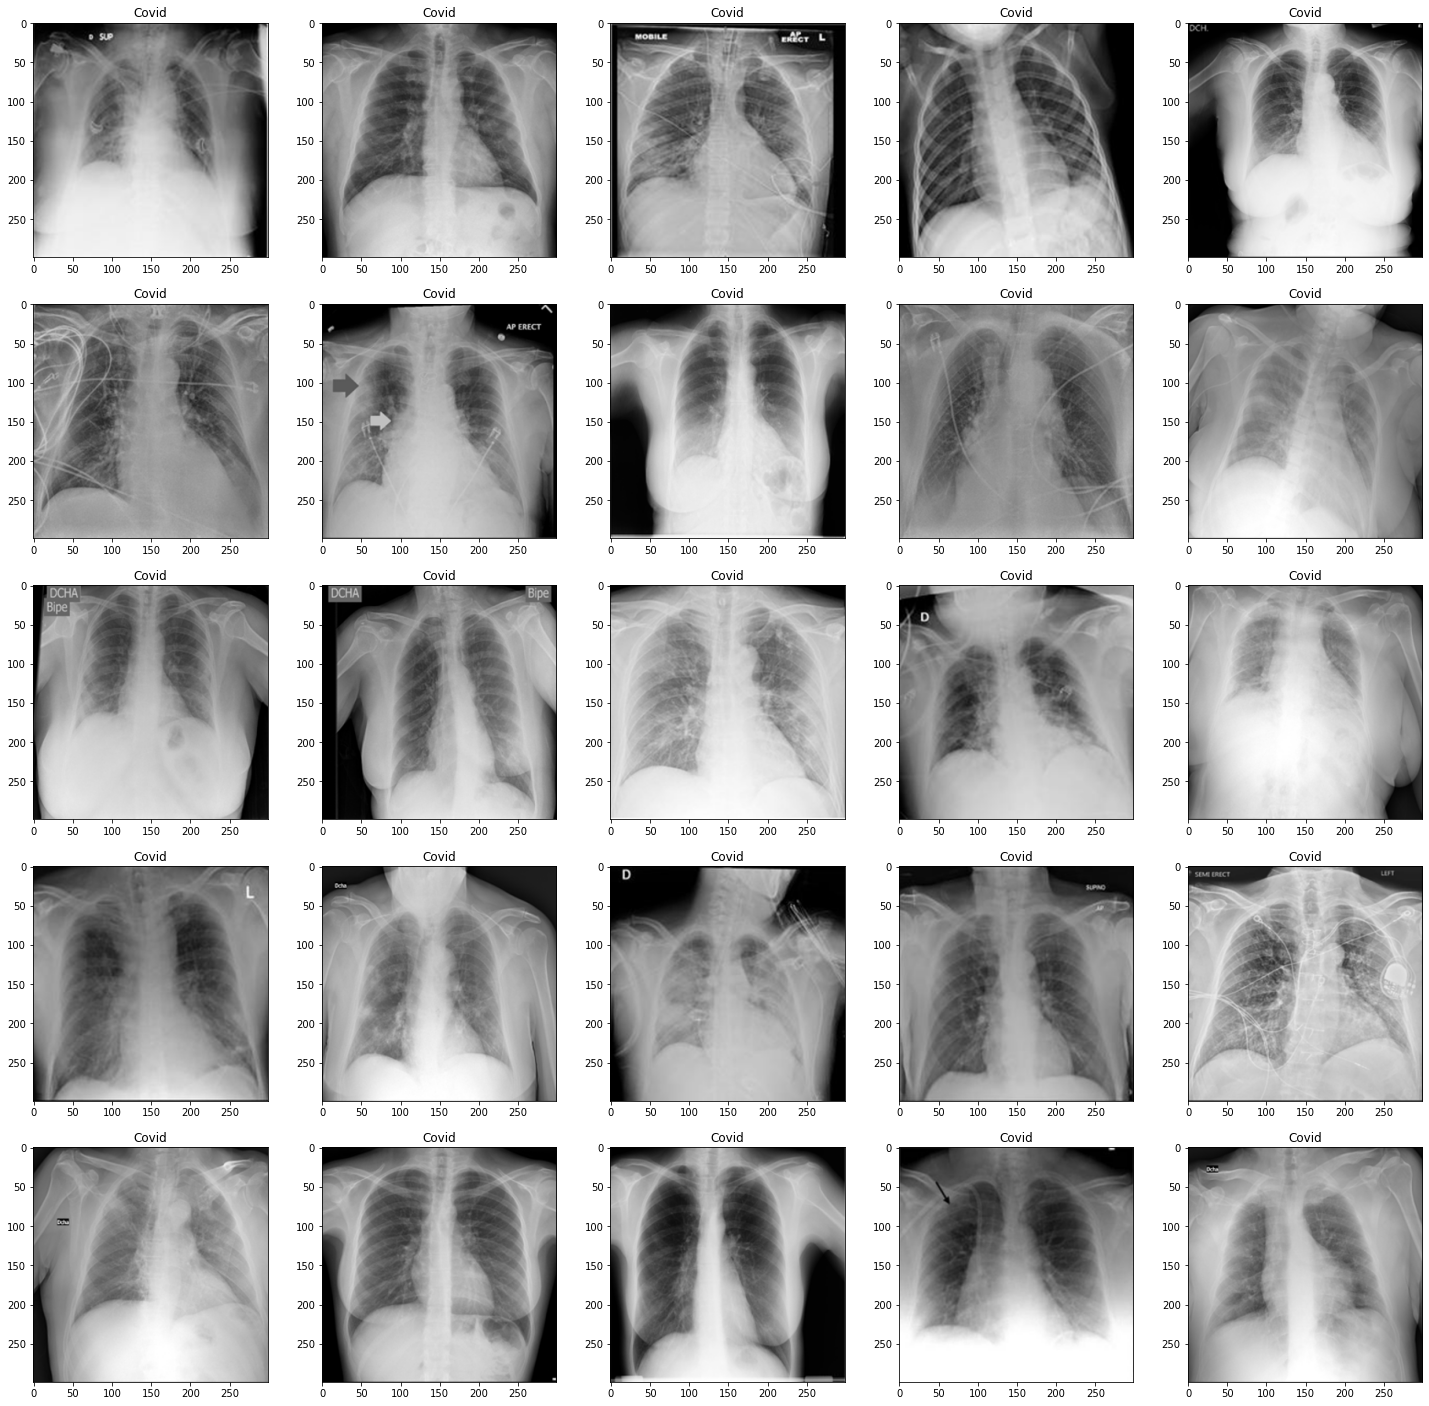

In [12]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']  
start = random.randint(0,len(temp))  
files = temp[start:start+25]        
                                    
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.imshow(img)
  plt.title('Covid')
  plt.axis()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


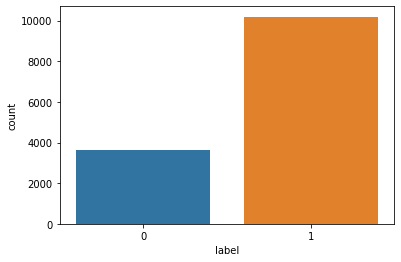

In [13]:
import seaborn as sns
sns.countplot(df['label'])

In [14]:
df['label'].value_counts()

1    10192
0     3616
Name: label, dtype: int64

In [15]:
df['label'].dtype

dtype('int64')

In [16]:
df['label'] = df['label'].astype('str')

In [17]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [18]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_generator = ImageDataGenerator(rescale=1./255)

train_iterator=train_generator.flow_from_dataframe(train,
                              x_col='images',
                              y_col='label',
                              target_size=(128,128),
                              batch_size=512,
                              class_mode='binary')

val_iterator=val_generator.flow_from_dataframe(train,
                              x_col='images',
                              y_col='label',
                              target_size=(128,128),
                              batch_size=512,
                              class_mode='binary')

Found 11046 validated image filenames belonging to 2 classes.
Found 11046 validated image filenames belonging to 2 classes.


In [19]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout

model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(rate=0.25))


model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.50))
model.add(Dense(1,activation='sigmoid'))

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

In [21]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
22/22 [==============================] - 123s 5s/step - loss: 0.8355 - accuracy: 0.7156 - val_loss: 0.6053 - val_accuracy: 0.7386
Epoch 2/10
22/22 [==============================] - 115s 5s/step - loss: 0.5800 - accuracy: 0.7386 - val_loss: 0.5838 - val_accuracy: 0.7386
Epoch 3/10
22/22 [==============================] - 107s 5s/step - loss: 0.5535 - accuracy: 0.7346 - val_loss: 0.5485 - val_accuracy: 0.7673
Epoch 4/10
22/22 [==============================] - 100s 5s/step - loss: 0.5202 - accuracy: 0.7459 - val_loss: 0.4936 - val_accuracy: 0.7615
Epoch 5/10
22/22 [==============================] - 100s 5s/step - loss: 0.4888 - accuracy: 0.7640 - val_loss: 0.4776 - val_accuracy: 0.7586
Epoch 6/10
22/22 [==============================] - 100s 5s/step - loss: 0.4832 - accuracy: 0.7741 - val_loss: 0.4645 - val_accuracy: 0.7620
Epoch 7/10
22/22 [==============================] - 100s 5s/step - loss: 0.4617 - accuracy: 0.7834 - val_loss: 0.4453 - val_accuracy: 0.7979
Epoch 8/10
22

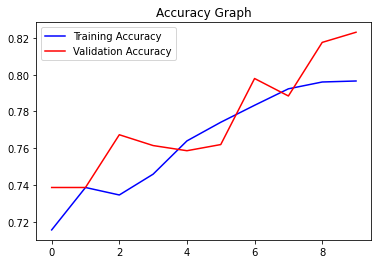

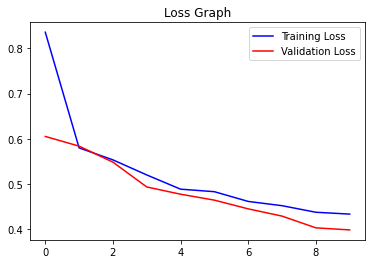

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

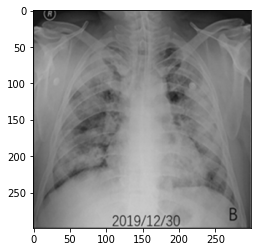

In [23]:
import cv2 
img=cv2.imread(r"/content/COVID-19_Radiography_Dataset/COVID/COVID-1014.png")
plt.imshow(img)
plt.show()

In [24]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r"/content/COVID-19_Radiography_Dataset/COVID/COVID-1014.png", target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
train_iterator.class_indices
if result[0][0] == 1:
  prediction = 'NORMAL'
else:
  prediction = 'COVID +ve'
print(prediction)

COVID +ve


In [25]:
from tensorflow.keras.models import load_model
model.save('//content/COVID-19_Radiography_Dataset/covid_detect.h5')